# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1861.7666015625
iteration 0 loss 57.827980041503906


iteration 5000 loss 0.1362142413854599


iteration 10000 loss 0.06926476210355759


iteration 15000 loss 0.0373506098985672


iteration 20000 loss 0.027251943945884705


iteration 25000 loss 0.13288502395153046


iteration 30000 loss 0.015583088621497154


iteration 35000 loss 0.012578165158629417


iteration 40000 loss 0.011030953377485275


iteration 45000 loss 0.028570115566253662


iteration 50000 loss 0.010601820424199104


iteration 55000 loss 0.007212987169623375


iteration 60000 loss 1.2020787000656128


iteration 65000 loss 0.012432218529284


iteration 70000 loss 0.005277616903185844


iteration 75000 loss 0.004848563112318516


iteration 80000 loss 0.004566473886370659


iteration 85000 loss 0.012144198641180992


iteration 90000 loss 0.004211066290736198


iteration 95000 loss 0.016765503212809563


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.003559279255568981


iteration 105000 loss 0.0030412250198423862


iteration 110000 loss 0.002796460408717394


iteration 115000 loss 0.00245411554351449


iteration 120000 loss 0.00227086222730577


iteration 125000 loss 0.002120363526046276


iteration 130000 loss 0.0020027298014611006


iteration 135000 loss 0.0018722283421084285


iteration 140000 loss 0.0017707895021885633


iteration 145000 loss 0.0016806648345664144


iteration 150000 loss 0.0015931843081489205


iteration 155000 loss 0.0015161671908572316


iteration 160000 loss 0.001449109986424446


iteration 165000 loss 0.0013844878412783146


iteration 170000 loss 0.0013219296233728528


iteration 175000 loss 0.001326605910435319


iteration 180000 loss 0.0012125626672059298


iteration 185000 loss 0.001171740936115384


iteration 190000 loss 0.0011188300559297204


iteration 195000 loss 0.001075770822353661


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0010362056782469153


iteration 205000 loss 0.0010194368660449982


iteration 210000 loss 0.0009844694286584854


iteration 215000 loss 0.0009526330977678299


iteration 220000 loss 0.0009226498659700155


iteration 225000 loss 0.0008939561666920781


iteration 230000 loss 0.00086666812421754


iteration 235000 loss 0.000839429849293083


iteration 240000 loss 0.0008180128643289208


iteration 245000 loss 0.0007903290679678321


iteration 250000 loss 0.0007683407748118043


iteration 255000 loss 0.0007467555114999413


iteration 260000 loss 0.0007257003453560174


iteration 265000 loss 0.0007062004879117012


iteration 270000 loss 0.0006856035906821489


iteration 275000 loss 0.0006676900084130466


iteration 280000 loss 0.0006504863849841058


iteration 285000 loss 0.0006340038380585611


iteration 290000 loss 0.0006179339252412319


iteration 295000 loss 0.0006016354309394956


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0005862956750206649


iteration 305000 loss 0.0005805484834127128


iteration 310000 loss 0.0005642075557261705


iteration 315000 loss 0.0005485530709847808


iteration 320000 loss 0.000532934267539531


iteration 325000 loss 0.0005189514486119151


iteration 330000 loss 0.0005046199657954276


iteration 335000 loss 0.000491547689307481


iteration 340000 loss 0.00047856534365564585


iteration 345000 loss 0.0004664868756663054


iteration 350000 loss 0.0004543998511508107


iteration 355000 loss 0.0004429973487276584


iteration 360000 loss 0.0004318757855799049


iteration 365000 loss 0.00042153976392000914


iteration 370000 loss 0.00041078729555010796


iteration 375000 loss 0.0004012087592855096


iteration 380000 loss 0.0003910634550265968


iteration 385000 loss 0.00038185258745215833


iteration 390000 loss 0.0003730579628609121


iteration 395000 loss 0.0003644700918812305


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0003563933714758605


iteration 405000 loss 0.0003533560084179044


iteration 410000 loss 0.0003447889175731689


iteration 415000 loss 0.00033633297425694764


iteration 420000 loss 0.00032812030985951424


iteration 425000 loss 0.0003201427753083408


iteration 430000 loss 0.00031240121461451054


iteration 435000 loss 0.00030488852644339204


iteration 440000 loss 0.0002975990646518767


iteration 445000 loss 0.0002905149303842336


iteration 450000 loss 0.00028362037846818566


iteration 455000 loss 0.00027690528077073395


iteration 460000 loss 0.0002703724894672632


iteration 465000 loss 0.00026401065406389534


iteration 470000 loss 0.0002578143903519958


iteration 475000 loss 0.0002517832617741078


iteration 480000 loss 0.00024590868270024657


iteration 485000 loss 0.00024017729447223246


iteration 490000 loss 0.00023461760429199785


iteration 495000 loss 0.00022919100592844188


L2 loss -- Plot

loss 19.61620330810547


loss -91.45531463623047


loss -168.53073120117188


loss -232.2098388671875


loss -284.7867431640625


loss -328.3482666015625


loss -364.5848693847656


loss -394.7575988769531


loss -419.788330078125


loss -440.375732421875


loss -457.0827331542969


loss -470.3929443359375


loss -480.7461242675781


loss -488.55853271484375


loss -494.2315368652344


loss -498.15399169921875


loss -500.7005615234375


loss -502.225341796875


loss -503.04925537109375


loss -503.44085693359375


loss -503.59967041015625


loss -503.6525573730469


loss -503.666259765625


loss -503.6687927246094


loss -503.6690979003906


loss -503.66912841796875


loss -503.66912841796875


loss -503.6690979003906


loss -503.6690979003906


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


loss -503.66912841796875


final mse:  3.254459757240369e-10
max, min: 7.0933123 -7.873737
loss 19.61620330810547


loss -94.65398406982422


loss -171.95089721679688


loss -235.84207153320312


loss -288.8374328613281


loss -332.835205078125


loss -369.5098571777344


loss -400.2161865234375


loss -425.94317626953125


loss -447.3974914550781


loss -465.1174621582031


loss -479.53387451171875


loss -491.0003662109375


loss -499.8335876464844


loss -506.36126708984375


loss -510.947998046875


loss -513.986328125


loss -515.86474609375


loss -516.9337768554688


loss -517.4827880859375


loss -517.7301025390625


loss -517.823974609375


loss -517.8525390625


loss -517.8590087890625


loss -517.8599853515625


loss -517.8600463867188


loss -517.8600463867188


loss -517.8599853515625


loss -517.8600463867188


loss -517.8600463867188


loss -517.8600463867188


loss -517.8600463867188


loss -517.8599853515625


loss -517.8600463867188


loss -517.8600463867188


loss -517.8600463867188


loss -517.8600463867188


loss -517.8600463867188


loss -517.8599853515625


loss -517.8600463867188


final mse:  3.235070544782559e-10
max, min: 7.6441293 -8.040427


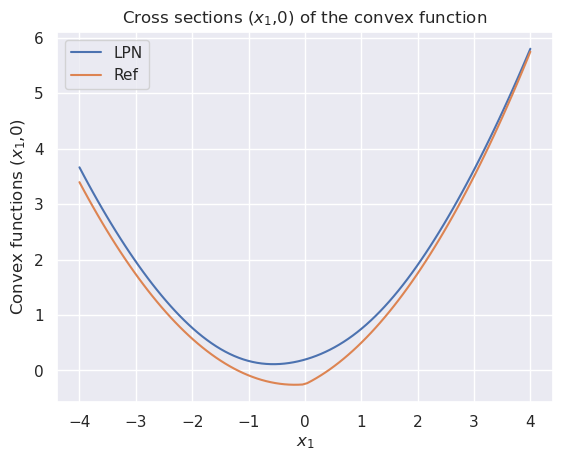

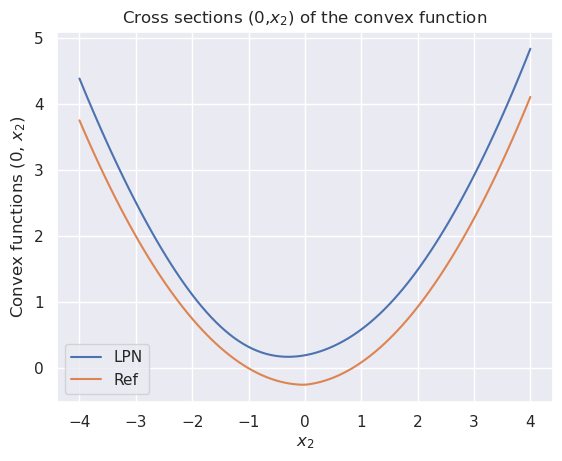

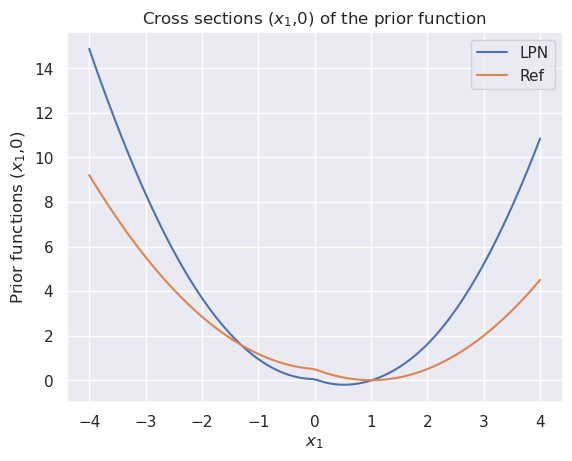

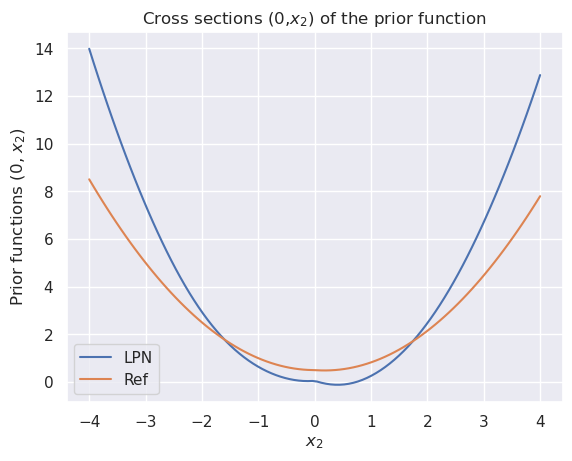

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


# --- Train 2nd LPN 
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 1727.630615234375
iteration 0 loss 540.6906127929688


iteration 5000 loss 0.20119939744472504


iteration 10000 loss 0.13771270215511322


iteration 15000 loss 0.06243530660867691


iteration 20000 loss 0.04753885418176651


iteration 25000 loss 0.036717310547828674


iteration 30000 loss 0.031157445162534714


iteration 35000 loss 0.02840380184352398


iteration 40000 loss 0.024849317967891693


iteration 45000 loss 0.02185874804854393


iteration 50000 loss 0.03426569700241089


iteration 55000 loss 0.018468672409653664


iteration 60000 loss 0.016503265127539635


iteration 65000 loss 0.01474568247795105


iteration 70000 loss 0.013729153200984001


iteration 75000 loss 0.012549389153718948


iteration 80000 loss 0.011927462182939053


iteration 85000 loss 0.011096407659351826


iteration 90000 loss 0.010377802886068821


iteration 95000 loss 0.009457841515541077


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.008769367821514606


iteration 105000 loss 0.008124837651848793


iteration 110000 loss 0.00746146822348237


iteration 115000 loss 0.0069579086266458035


iteration 120000 loss 0.00651061674579978


iteration 125000 loss 0.006151437293738127


iteration 130000 loss 0.005829902831465006


iteration 135000 loss 0.006275426596403122


iteration 140000 loss 0.005264043342322111


iteration 145000 loss 0.005015371832996607


iteration 150000 loss 0.004789585713297129


iteration 155000 loss 0.004574087914079428


iteration 160000 loss 0.0043758610263466835


iteration 165000 loss 0.004194298293441534


iteration 170000 loss 0.0040234592743217945


iteration 175000 loss 0.003863357938826084


iteration 180000 loss 0.003712922567501664


iteration 185000 loss 0.003568480256944895


iteration 190000 loss 0.004728109575808048


iteration 195000 loss 0.003308043582364917


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.003192368196323514


iteration 205000 loss 0.003138499101623893


iteration 210000 loss 0.0030231804121285677


iteration 215000 loss 0.002919858554378152


iteration 220000 loss 0.0028245365247130394


iteration 225000 loss 0.0027322466485202312


iteration 230000 loss 0.002643479034304619


iteration 235000 loss 0.002554694190621376


iteration 240000 loss 0.002474292879924178


iteration 245000 loss 0.002398284152150154


iteration 250000 loss 0.0023248735815286636


iteration 255000 loss 0.0022562395315617323


iteration 260000 loss 0.002191771287471056


iteration 265000 loss 0.0021310707088559866


iteration 270000 loss 0.0020728614181280136


iteration 275000 loss 0.0020159725099802017


iteration 280000 loss 0.001959152752533555


iteration 285000 loss 0.001908389967866242


iteration 290000 loss 0.0018558932933956385


iteration 295000 loss 0.0018085543997585773


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0017623011954128742


iteration 305000 loss 0.00175095209851861


iteration 310000 loss 0.0017002245876938105


iteration 315000 loss 0.0016472081188112497


iteration 320000 loss 0.001598437549546361


iteration 325000 loss 0.0015494897961616516


iteration 330000 loss 0.001503178384155035


iteration 335000 loss 0.001459873397834599


iteration 340000 loss 0.0014189527137205005


iteration 345000 loss 0.001380550442263484


iteration 350000 loss 0.001345261582173407


iteration 355000 loss 0.00130854407325387


iteration 360000 loss 0.0012730159796774387


iteration 365000 loss 0.0012390360934659839


iteration 370000 loss 0.0012097408762201667


iteration 375000 loss 0.001179961720481515


iteration 380000 loss 0.0011506857117637992


iteration 385000 loss 0.0011355903698131442


iteration 390000 loss 0.0010954781901091337


iteration 395000 loss 0.001069223741069436


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0010435073636472225


iteration 405000 loss 0.001035307883284986


iteration 410000 loss 0.0010162105318158865


iteration 415000 loss 0.0009975761640816927


iteration 420000 loss 0.0009795232908800244


iteration 425000 loss 0.0009619756601750851


iteration 430000 loss 0.0009449007920920849


iteration 435000 loss 0.0009282534592784941


iteration 440000 loss 0.0009120267350226641


iteration 445000 loss 0.0008961774874478579


iteration 450000 loss 0.0008806870901025832


iteration 455000 loss 0.0008655440178699791


iteration 460000 loss 0.0008507348829880357


iteration 465000 loss 0.0008362421067431569


iteration 470000 loss 0.0008220438612625003


iteration 475000 loss 0.0008081360720098019


iteration 480000 loss 0.0007945098914206028


iteration 485000 loss 0.0007811717805452645


iteration 490000 loss 0.0007680985727347434


iteration 495000 loss 0.0007552660536020994


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


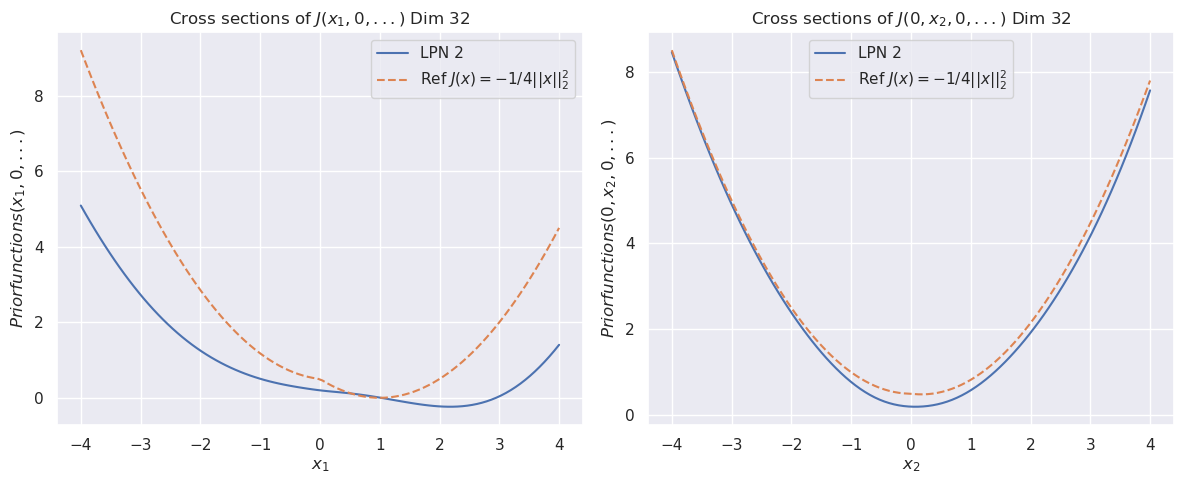

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)